In [1]:
from pybaseball import statcast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = statcast(start_dt="2025-03-18", end_dt="2025-10-03")

This is a large query, it may take a moment to complete


/Users/jakeb/miniconda3/lib/python3.12/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 1/200 [00:00<02:25,  1.37it/s]/Users/jakeb/miniconda3/lib/python3.12/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly ins

In [3]:
balls = data[data['description'] == 'ball']
cstrikes = data[data['description'] == 'called_strike']

bball_diameter = (2.9 / 12) #we will later add a margin the size of a baseball's diameter, as a strike is defined by any part of the ball passing through any part of the plane
hp_width = (8.5 / 12) #Hp is 17 inches wide, so 8.5 inches to the left or right of center will be a strike

In [4]:

"""There is probably a simpler way to do this but the Statcast data only provided the MLBAMID number for the hitters. So, I found one CSV that had all MLBAMID numbers with the players name and another CSV with the player's name and height, so I had to do 2 joins to get this all in one table"""

people_data_filepath='insert file path for People (1).csv'


#table that has all players and their heights
peopledata = pd.read_csv('People (1).csv')

filtered_pd = peopledata[peopledata['finalGame'].isna() | (peopledata['finalGame'] == '')].copy() #only keep for active players
filtered_pd['Full Name'] = filtered_pd['nameFirst'].astype(str) + ' ' + filtered_pd['nameLast'].astype(str) #make a column for first name space last name to join with next table

In [5]:

razzball_file_path='insert file path for razzball.csv'

#get table with MLBAMIDS

idcsv=pd.read_csv('razzball.csv')

merged_pd = pd.merge(filtered_pd, idcsv, left_on='Full Name', right_on='Name', how='right') #join tables on name

#ABS defines the top of the strikezone as 53.5% of the batter's height, and the bottom as 27% of the batter's height
merged_pd['max_height'] = ((merged_pd['height'] * .535) / 12)+bball_diameter
merged_pd['min_height'] = ((merged_pd['height'] * .27) / 12)-bball_diameter




In [6]:
ndata = pd.merge(data, merged_pd[['MLBAMID', 'max_height', 'min_height']], left_on='batter', right_on='MLBAMID', how='inner')

nndata=ndata[['batter', 'pitcher', 'description', 'pitch_type',
               'plate_x', 'plate_z', 'min_height', 'max_height']]

cols_needed = ['plate_x', 'plate_z', 'max_height', 'min_height']
nndata = nndata.dropna(subset=cols_needed) #drop NA columns
nndata=nndata[(nndata['description']=='ball')|(nndata['description']=='called_strike')] #only keep called strikes and balls

In [7]:


nndata['abs_strike'] = np.where(
    ((nndata['plate_x'] > -(hp_width-bball_diameter)) & (nndata['plate_x'] < (hp_width+bball_diameter))) &
    ((nndata['plate_z'] > (nndata['min_height']-bball_diameter)) & (nndata['plate_z'] < (nndata['max_height']+bball_diameter))),
    1, 0)


In [8]:

abs_strike = nndata[nndata['abs_strike'] == 1]
abs_ball = nndata[nndata['abs_strike'] == 0]


total acc = 82.38%


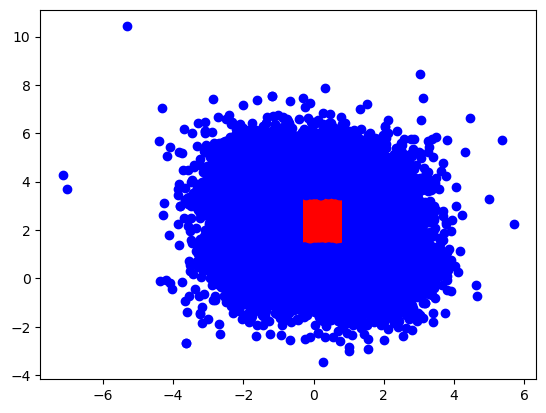

In [9]:
plt.scatter(abs_strike['plate_x'], abs_strike['plate_z'], color='red', label='abs strike')
plt.scatter(abs_ball['plate_x'], abs_ball['plate_z'], color='blue', label='abs ball')
true_strike = nndata[(nndata['abs_strike'] == 1) & (nndata['description'] == 'called_strike')]
true_ball = nndata[(nndata['abs_strike'] == 0) & (nndata['description'] == 'ball')]
false_strike = nndata[(nndata['abs_strike'] == 0) & (nndata['description'] == 'called_strike')]
false_ball = nndata[(nndata['abs_strike'] == 1) & (nndata['description'] == 'ball')]

print(f'total acc = {round((len(true_strike) + len(true_ball)) / len(nndata) * 100, 2)}%')



In [10]:
fs_percent=(false_strike['pitch_type'].value_counts()*100)/(nndata['pitch_type'].value_counts())
fb_percent=(false_ball['pitch_type'].value_counts()*100)/(nndata['pitch_type'].value_counts())

#exlcude rarely thwon pitches like eephus, knuckleball, slow curve, screwball, etc
fs_percent = fs_percent[~fs_percent.index.isin(['EP', 'KN','CS','SC','FO'])]
fb_percent = fb_percent[~fb_percent.index.isin(['EP', 'KN','CS','SC','FO'])]

fs_percent = fs_percent.sort_values(ascending=False)
fb_percent = fb_percent.sort_values(ascending=False)

fs_percent_str = fs_percent.round(2).astype(str) + '%'
fb_percent_str = fb_percent.round(2).astype(str) + '%'

print(fs_percent_str)
print(fb_percent_str)

pitch_type
FA    9.85%
CU     8.3%
SI    8.29%
FF    7.91%
SV    7.74%
KC    7.51%
FC    7.48%
SL    6.64%
ST    6.59%
FS    5.09%
CH    4.74%
Name: count, dtype: object
pitch_type
SI    11.56%
FC    10.93%
CH    10.67%
SL    10.65%
FS     9.98%
FF     9.95%
CU     9.15%
ST     9.04%
KC     8.88%
SV     7.55%
FA     7.46%
Name: count, dtype: object


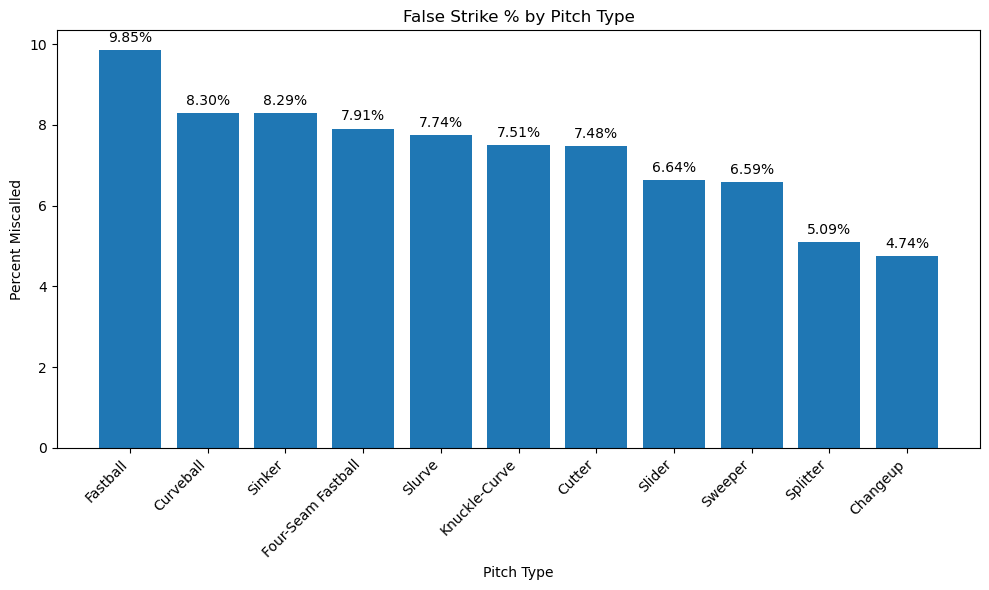

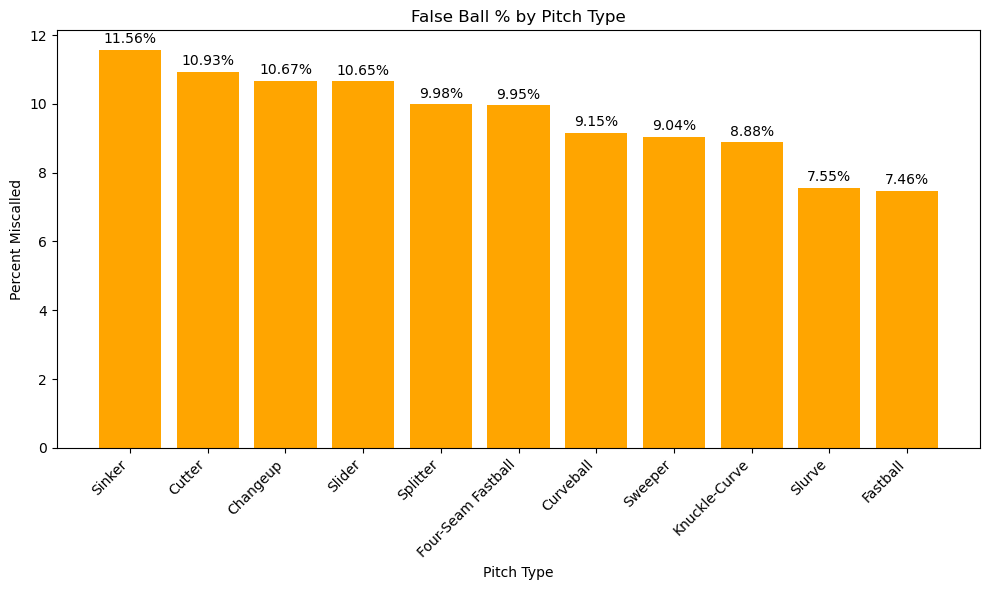

In [11]:

pitch_dict={'CU':'Curveball','KC':'Knuckle-Curve','SV':'Slurve','FA':'Fastball','FF':'Four-Seam Fastball','FS':'Splitter','FC':'Cutter','SI':'Sinker','ST':'Sweeper','SL':'Slider','CH':'Changeup'}


# Map abbreviations to full names for plotting
fs_labels = [pitch_dict.get(p, p) for p in fs_percent.index]
fb_labels = [pitch_dict.get(p, p) for p in fb_percent.index]

# false strikes bar chart
plt.figure(figsize=(10,6))
plt.bar(fs_labels, fs_percent.values)
plt.title("False Strike % by Pitch Type")
plt.xlabel("Pitch Type")
plt.ylabel("Percent Miscalled")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(fs_percent.values):
    plt.text(i, v + 0.2, f"{v:.2f}%", ha='center')
plt.tight_layout()
plt.savefig("false_strikes_abs.png", dpi=300, bbox_inches="tight")
plt.show()

# false balls bar chart
plt.figure(figsize=(10,6))
plt.bar(fb_labels, fb_percent.values, color='orange')
plt.title("False Ball % by Pitch Type")
plt.xlabel("Pitch Type")
plt.ylabel("Percent Miscalled")
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(fb_percent.values):
    plt.text(i, v + 0.2, f"{v:.2f}%", ha='center')
plt.savefig("falls_balls_abs.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()



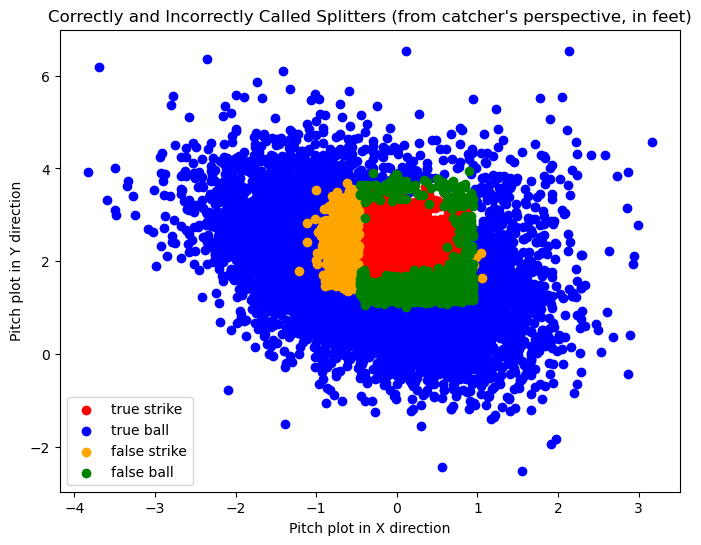

In [12]:
# filter only specific pitch
pitch_abbreviation='FS' #can change to any pitch desired
ts_pitch = true_strike[true_strike['pitch_type'] == pitch_abbreviation]
tb_pitch = true_ball[true_ball['pitch_type'] == pitch_abbreviation]
fs_pitch = false_strike[false_strike['pitch_type'] == pitch_abbreviation]
fb_pitch = false_ball[false_ball['pitch_type'] == pitch_abbreviation]

plt.figure(figsize=(8,6))
plt.scatter(ts_pitch['plate_x'], ts_pitch['plate_z'], color='red', label='true strike')
plt.scatter(tb_pitch['plate_x'], tb_pitch['plate_z'], color='blue', label='true ball')
plt.scatter(fs_pitch['plate_x'], fs_pitch['plate_z'], color='orange', label='false strike')
plt.scatter(fb_pitch['plate_x'], fb_pitch['plate_z'], color='green', label='false ball')

plt.xlabel('Pitch plot in X direction')
plt.ylabel('Pitch plot in Y direction')
plt.title(f'Correctly and Incorrectly Called {pitch_dict[pitch_abbreviation]}s (from catcher\'s perspective, in feet)')
plt.legend()
plt.show()


In [13]:
margin = 0.5 * bball_diameter



# Define "close" pitches as those within half of a baseball's diameter from the strike zone edges


marginal_pitches = nndata[
    (
        # close to top or bottom edge
        ((nndata['plate_z'] >= nndata['max_height'] - margin) & (nndata['plate_z'] <= nndata['max_height'] + margin)) |
        ((nndata['plate_z'] >= nndata['min_height'] - margin) & (nndata['plate_z'] <= nndata['min_height'] + margin)) |
        ((nndata['plate_x'] >= -hp_width - margin) & (nndata['plate_x'] <= -hp_width + margin)) |
        ((nndata['plate_x'] >=  hp_width - margin) & (nndata['plate_x'] <=  hp_width + margin))
    )]


marginal_percent = round((len(marginal_pitches) / len(ndata)) * 100,2)

print(f'{marginal_percent}% of pitches are considered \"marginal\"')


10.81% of pitches are considered "marginal"
